In [67]:
import torch
import torch.nn as nn
import os
import math

In [80]:
class MGP(nn.Module):
    def __init__(self, X_L, y_L, X_H, y_H, feature_dim):
        super(MGP, self).__init__()
        self.D = X_H.shape[1]
        self.X_L = X_L
        self.y_L = y_L
        self.X_H = X_H
        self.y_H = y_H
        
        self.feature_dim = feature_dim
        hidden_dim = 2 * feature_dim
        self.Linear1 = nn.Linear(self.D, hidden_dim)
        self.Linear2 = nn.Linear(hidden_dim, feature_dim)
        self.ReLU = nn.Sigmoid()
        self.hyp = self.init_params()
        print("Total number of parameters: %d" % (self.hyp.shape[0]))
        self.jitter = 1e-8
        
    def feature_get(self, X):
        hidden_layer = self.Linear1(X)
        ReLU_layer = self.ReLU(hidden_layer)
        output_layer = self.Linear2(ReLU_layer)
        return output_layer
    
    def init_params(self):
        hyp = torch.log(torch.ones(self.feature_dim + 1))
#         hyp = torch.log(torch.ones(self.D + 1))
        self.idx_theta_L = torch.arange(hyp.shape[0])

        hyp = torch.cat([hyp, torch.log(torch.ones(self.feature_dim + 1))])
#         hyp = torch.cat([hyp, torch.log(torch.ones(self.D + 1))])
        self.idx_theta_H = torch.arange(self.idx_theta_L[-1] + 1, hyp.shape[0])

        rho = torch.tensor([1.0])
        logsigma_n = torch.tensor([-4.0, -4.0])
        hyp = torch.cat([hyp, rho, logsigma_n])
        hyp = torch.nn.Parameter(hyp, requires_grad=True)
        return hyp
    
    def kernel(self, x, xp, hyp):
        output_scale = torch.exp(hyp[0])
        lengthscales = torch.exp(hyp[1:])
        diffs = torch.unsqueeze(x / lengthscales, 1) - \
                torch.unsqueeze(xp / lengthscales, 0)
        return output_scale * torch.exp(-0.5 * torch.sum(diffs ** 2, axis=2))
    
    def likelihood(self, hyp):
        X_L = self.feature_get(self.X_L)
#         X_L = self.X_L
        y_L = self.y_L
        X_H = self.feature_get(self.X_H)
#         X_H = self.X_H
        y_H = self.y_H

        y = torch.cat((y_L, y_H), dim=0)

        NL = y_L.shape[0]
        NH = y_H.shape[0]
        N = y.shape[0]

        rho = hyp[-3]
        logsigma_n_L = hyp[-2]
        logsigma_n_H = hyp[-1]
        sigma_n_L = torch.exp(logsigma_n_L)
        sigma_n_H = torch.exp(logsigma_n_H)

        theta_L = hyp[self.idx_theta_L]
        theta_H = hyp[self.idx_theta_H]

        K_LL = self.kernel(X_L, X_L, theta_L) + torch.eye(NL) * sigma_n_L
        K_LH = rho * self.kernel(X_L, X_H, theta_L)
        K_HH = rho ** 2 * self.kernel(X_H, X_H, theta_L) + \
               self.kernel(X_H, X_H, theta_H) + torch.eye(NH) * sigma_n_H
        K = torch.cat((torch.cat((K_LL, K_LH), dim=1),
                          torch.cat((K_LH.T, K_HH), dim=1)), dim=0)
        L = torch.cholesky(K + torch.eye(N) * self.jitter)
        self.L = L

        alpha = torch.solve(torch.solve(y, L).solution, L.T).solution
        NLML = 0.5 * torch.matmul(y.T, alpha) + \
               torch.sum(torch.log(torch.diag(L))) + 0.5 * np.log(2. * np.pi) * N
        return NLML[0, 0]
    
    def forward(self):
        result = self.likelihood(self.hyp)
        return result
    
    def predict(self, X_star_raw):
        X_L = self.feature_get(self.X_L)
#         X_L = self.X_L
        y_L = self.y_L
        X_H = self.feature_get(self.X_H)
#         X_H = self.X_H
        y_H = self.y_H
        L = self.L
        X_star = self.feature_get(X_star_raw)
#         X_star = X_star_raw

        y = torch.cat((y_L, y_H), dim=0)

        rho = self.hyp[-3]
        theta_L = self.hyp[self.idx_theta_L]
        theta_H = self.hyp[self.idx_theta_H]

        psi1 = rho * self.kernel(X_star, X_L, theta_L)
        psi2 = rho ** 2 * self.kernel(X_star, X_H, theta_L) + \
               self.kernel(X_star, X_H, theta_H)
        psi = torch.cat((psi1, psi2), dim=1)

        alpha = torch.solve(torch.solve(y, L).solution, L.T).solution
        pred_u_star = torch.matmul(psi, alpha.T)

        beta = torch.solve(torch.solve(psi.T,L).solution, L.T).solution
        var_u_star = rho ** 2 * self.kernel(X_star, X_star, theta_L) + \
                     self.kernel(X_star, X_star, theta_H) - torch.matmul(psi, beta)

        return pred_u_star, var_u_star
    
    def callback(self, params):
        print("Log likelihood {}".format(self.likelihood(params)))

In [81]:
import autograd.numpy as np
import torch
import matplotlib.pyplot as plt
from pyDOE import lhs
from Handwritten_Deep_Multi_Gaussian import Multifidelity_GP
from sklearn.metrics import r2_score
%matplotlib inline  
np.random.seed(1234)

In [82]:
def f_H(x):
    return (6.0*x-2.0)**2 * np.sin(12.*x-4.0)

def f_L(x):
    return 0.5*f_H(x) + 10.0*(x-0.5) - 5.0

def Normalize(X, X_m, X_s):
    return (X-X_m)/(X_s)

In [83]:
N_H = 3
N_L = 8
D = 1
lb = 0.0*np.ones(D)
ub = 1.0*np.ones(D)
noise_L = 0.00
noise_H = 0.00

Normalize_input_data = 1
Normalize_output_data = 1

Text(0, 0.5, '$f(x)$')

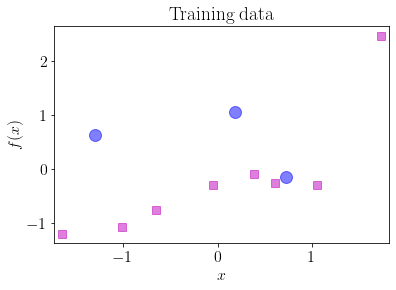

In [84]:
# Training data    
X_L = lb + (ub-lb)*lhs(D, N_L)
y_L = f_L(X_L) + noise_L*np.random.randn(N_L,D)

X_H = lb + (ub-lb)*lhs(D, N_H)
y_H = f_H(X_H) + noise_H*np.random.randn(N_H,D)

# Test data
nn1 = 200
X_star = np.linspace(lb, ub, nn1)[:,None]
y_star = f_H(X_star)

 #  Normalize Input Data
if Normalize_input_data == 1:
    X = np.vstack((X_L,X_H))
    X_m = np.mean(X, axis = 0)
    X_s = np.std(X, axis = 0)   
    X_L = Normalize(X_L, X_m, X_s)
    X_H = Normalize(X_H, X_m, X_s)
    lb = Normalize(lb, X_m, X_s)
    ub = Normalize(ub, X_m, X_s)
    X_star = Normalize(X_star, X_m, X_s)

#  Normalize Output Data
if Normalize_output_data == 1:
    y = np.vstack((y_L,y_H))
    y_m = np.mean(y, axis = 0)
    y_s = np.std(y, axis = 0)   
    y_L = Normalize(y_L, y_m, y_s)
    y_H = Normalize(y_H, y_m, y_s)
    y_star = Normalize(y_star, y_m, y_s)
    
# Plot the training data
plt.figure(facecolor='w')
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=16)
plt.plot(X_H,y_H,'bo', markersize = 12, alpha = 0.5, label = "Data")
plt.plot(X_L,y_L,'ms', markersize = 8, alpha = 0.5, label = "Data")
plt.title("Training data")
ax = plt.gca()
ax.set_xlim([lb[0], ub[0]])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

In [85]:
feature_dim = 1

X_L=torch.from_numpy(X_L).float()
X_H=torch.from_numpy(X_H).float()
y_L=torch.from_numpy(y_L).float()
y_H=torch.from_numpy(y_H).float()


In [86]:
print(X_L)

tensor([[-1.0127],
        [ 1.0497],
        [-0.0541],
        [-1.6465],
        [ 0.6049],
        [-0.6513],
        [ 1.7256],
        [ 0.3866]])


In [87]:
model = MGP(X_L, y_L, X_H, y_H,feature_dim)

Total number of parameters: 7


In [88]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# model.hyp
# for parameters in model.parameters():
#     print(parameters)

In [89]:
epoches = 5000

for e in range(epoches):
    optimizer.zero_grad()
    loss = model()
    if (e)%100==0:
        print(f'epoch: {e}  loss: {loss.item()}')
    loss.backward()
    optimizer.step()

epoch: 0  loss: 252.182861328125
epoch: 100  loss: 34.57688903808594
epoch: 200  loss: 10.791662216186523
epoch: 300  loss: 9.900952339172363
epoch: 400  loss: 9.432966232299805
epoch: 500  loss: 9.1715087890625
epoch: 600  loss: 9.006244659423828
epoch: 700  loss: 8.877553939819336
epoch: 800  loss: 8.760381698608398
epoch: 900  loss: 8.643878936767578
epoch: 1000  loss: 8.523284912109375
epoch: 1100  loss: 8.396501541137695
epoch: 1200  loss: 8.262460708618164
epoch: 1300  loss: 8.120140075683594
epoch: 1400  loss: 7.967472076416016
epoch: 1500  loss: 7.799771308898926
epoch: 1600  loss: 7.606085300445557
epoch: 1700  loss: 7.364133358001709
epoch: 1800  loss: 7.068902969360352
epoch: 1900  loss: 6.841186046600342
epoch: 2000  loss: 6.6942644119262695
epoch: 2100  loss: 6.5694451332092285
epoch: 2200  loss: 6.454970359802246
epoch: 2300  loss: 6.348260402679443
epoch: 2400  loss: 6.248693466186523
epoch: 2500  loss: 6.156641960144043
epoch: 2600  loss: 6.072801113128662
epoch: 2700  

In [90]:
X_star=torch.from_numpy(X_star).float()

In [91]:
# Predict
y_pred, y_var = model.predict(X_star)
y_pred, y_var = y_pred.detach().numpy(), y_var.detach().numpy()
y_var = np.abs(np.diag(y_var))

# Check accuracy                       
error = np.linalg.norm(y_pred-y_star,2)/np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

# Plot
plt.figure(1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=16)
plt.plot(X_star, y_star, 'b-', label = "Exact", linewidth=2)
plt.plot(X_star, y_pred, 'r--', label = "Prediction", linewidth=2)
lower = y_pred - 2.0*np.sqrt(y_var[:,None])
upper = y_pred + 2.0*np.sqrt(y_var[:,None])
plt.fill_between(X_star.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.5, label="Two std band")
plt.plot(X_H,y_H,'bo', markersize = 12, label = "High-fidelity data")
plt.plot(X_L,y_L,'ms', markersize = 8, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
ax.set_xlim([lb[0], ub[0]])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

RuntimeError: Incompatible matrix sizes for solve: each A matrix is 11 by 11 but each b matrix is 2 by 200

In [12]:
# model.hyp
# for parameters in model.parameters():
#     print(parameters)

In [13]:
y_pred, y_var = model.predict(X_star)
y_pred, y_var = y_pred.detach().numpy(), y_var.detach().numpy()

Relative L2 error u: 6.855246e-02
r2 socre: 0.15881388698211096
[[31.1779]
 [29.1824]
 [26.4095]
 [26.9644]
 [30.09  ]
 [26.837 ]
 [25.28  ]
 [31.4606]
 [30.1555]] [[29.56369 ]
 [30.170456]
 [27.194271]
 [30.035992]
 [26.118118]
 [26.552925]
 [24.604034]
 [29.471863]
 [29.190376]]
[0.01564633 0.01910804 0.02554493 0.00883754 0.0160188  0.02253916
 0.03544086 0.01349343 0.01754244]


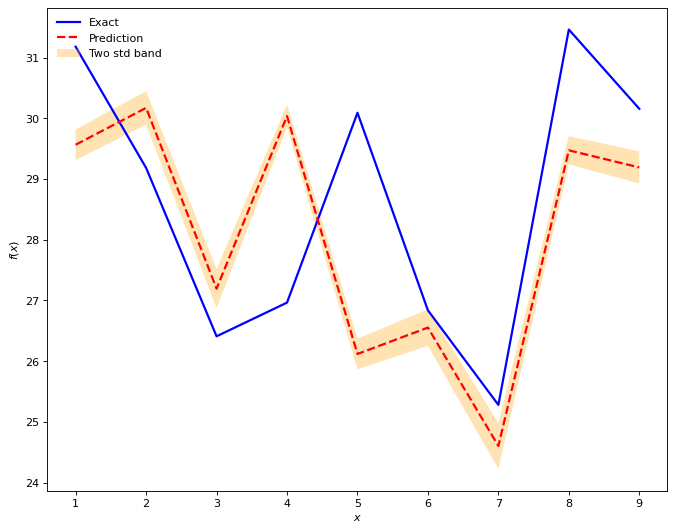

In [14]:
file_write_obj = open("5.without-norm-2000-epoch-feature48-lr5e-4.txt", 'w')
# for var in mylist:
#     file_write_obj.writelines(var)
#     file_write_obj.write('\n')


# Check accuracy                       
error = np.linalg.norm(y_pred - y_star,2) / np.linalg.norm(y_star,2)
print("Relative L2 error u: %e" % (error))

file_write_obj.write('Relative L2 error')
file_write_obj.write(str(error))
file_write_obj.write('\n')

index=[1,2,3,4,5,6,7,8,9]
y_pred=np.array(y_pred)
y_star=np.array(y_star)

print("r2 socre:",r2_score(y_star,y_pred))

file_write_obj.write('r2 socre')
file_write_obj.writelines(str(r2_score(y_star,y_pred)))
file_write_obj.write('\n')

print(y_star, y_pred)
file_write_obj.write('Exact')
file_write_obj.write(str(y_star))
file_write_obj.write('\n')

file_write_obj.write('Predict')
file_write_obj.write(str(y_pred))
file_write_obj.write('\n')

y_var_new=abs(y_var.mean(axis=1))
print(y_var_new)

file_write_obj.write('std')
file_write_obj.write(str(y_var_new))
file_write_obj.write('\n')

# Plot
plt.figure(1, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.rc('text', usetex=True)
# plt.rc('font', family='serif', size=12)


# plt.plot(X_star, y_star, 'b-', label = "Exact", linewidth=2)
# plt.plot(X_star, y_pred, 'r--', label = "Prediction", linewidth=2)
plt.plot(index, y_star, 'b-', label = "Exact", linewidth=2)
plt.plot(index, y_pred, 'r--', label = "Prediction", linewidth=2)


lower = np.array(y_pred - 2.0*np.sqrt(y_var_new[:,None]))
upper = np.array(y_pred + 2.0*np.sqrt(y_var_new[:,None]))

                     
index=np.array(index)
plt.fill_between(index.flatten(), lower.flatten(), upper.flatten(), 
                 facecolor='orange', alpha=0.3, label="Two std band")
# plt.plot(X_H,y_H,'bo', markersize = 1, label = "High-fidelity data")
# plt.plot(X_L,y_L,'ms', markersize = 1, label = "Low-fidelity data")
plt.legend(frameon=False,loc='upper left')
ax = plt.gca()
plt.xlabel('$x$')
plt.ylabel('$f(x)$')

plt.savefig("5.without-norm-2000-epoch-feature48-lr5e-4.png")
file_write_obj.close()
